# Part 0: Introduction and Imports

This project guides you through the general pipeline used to train convolutional neural networks in the real-world, with a couple of example image classification tasks. We will be using a library called Keras which simplifies many of the low-level implementation details of neural networks for us, so that we can focus on the high-level deep learning concepts.

### New to Jupyter notebooks?
Check out this [quick video introduction](https://www.youtube.com/watch?v=jZ952vChhuI) to Jupyter notebooks before starting, and feel free to post on Piazza if you run into any issues.

### Using this notebook
This notebook will walk you through the different parts of the assignment, with detailed instructions and explanations at every step - use this as your project write-up. **All of your code needs to be written in the `student.py` file, not here!** As you come across TODO tasks, the notebook will provide explanations of what you need to do in `student.py`. Every time a cell that contains `%aimport student` at the top is run, it will auto-reload the functions in `student.py`.

### Your code
Once again, **all of your code needs to be written in `student.py`, and not in this notebook!** We will not grade any code written in this notebook (since you will not be submitting it); this notebook is meant to serve as a central tool that you can use to run your code and visualize your outputs. It also contains detailed explanations at every step to guide you. If anything is unclear, please post on Piazza!

### Questions after Parts 1, 2, and 3
There are a few short questions that you will need to answer after completing Parts 1, 2, and 3. They are listed within the notebook, and also in `student.py`, but **all answers should go in `student.py`**. We have provided space for answers (as a comment) in `student.py`. Keep these answers brief; 1-2 lines each should be sufficient!

### Python version
The top-right of this notebook should display a Python version; please make sure that it says Python 2 before proceeding!

In [1]:
%load_ext autoreload
%autoreload 1

# Imports
import keras
import numpy as np
from keras import backend as K
from keras.datasets import cifar10
from keras.models import Model
from keras.optimizers import Adam
from matplotlib import pyplot as plt
from scipy.misc import bytescale

# Constants
cifar_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
av_classes = ['animal', 'vehicle']

/home/ubuntu/anaconda2/envs/pa5/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Running the cell above should give you a message along the lines of `Using TensorFlow backend` - if it doesn't, please ask us on Piazza!

Keras is a wrapper library that provides a high-level API to more complex deep learning libraries. In our case, we will be using TensorFlow (Google's deep learning library) under the hood as Keras' backend.

# Part 1: Reading the data

#### Step 1: Downloading the dataset

The cell below uses an in-built Keras function to retrieve the CIFAR-10 dataset from the internet. The dataset consists of 50,000 training images and labels, which are parsed into `x` and `y_raw`, and an additional 10,000 images and labels are kept separately as a test set, and are parsed into `x_t`, `y_t_raw`. Run the cell below to download the dataset!

This cell might take more than a few seconds to run, since it's downloading 60,000 images! For reference, it took 17 seconds to complete on the campus internet connection. **If you are working within the course VM, and any of the following cells fails because of a memory error, try quitting your VM and increasing the amount of memory available to the VM.**

In [2]:
(x, y_raw), (x_t, y_t_raw) = cifar10.load_data()
print(x.shape, y_raw.shape, x_t.shape, y_t_raw.shape)

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))


#### Step 2: Converting the labels to one-hot vectors

The CIFAR-10 labels stored in `y_raw` and `y_t_raw` are encoded as simple integers, from 0 to 9. However, we need to use a one-hot encoding instead of an integer encoding to effectively train our models. This means that the label 0 should instead be encoded as a vector where the 0'th entry is 1, and the entries for every other class is 0. In the case of CIFAR-10, we have 10 classes, so label 0 should produce the vector [1 0 0 0 0 0 0 0 0 0].

**TODO 1**: In `student.py`, implement the function, `labels_to_one_hot`, which takes as input an (n x 1) list of integer labels, and converts each of the n labels to its corresponding one-hot encoding depending on the number of classes (given by `num_classes`). Note that this should work for any number of classes, not just the 10-class example!

Once you have completed TODO 1, run the following cell to convert `y_raw` and `y_t_raw` into one-hot vectors (`y` and `y_t`). Check that they look like what you expect, and that their shapes match up with the specification of `labels_to_one_hot`.

In [3]:
%aimport student

y = student.labels_to_one_hot(y_raw, 10)
y_t = student.labels_to_one_hot(y_t_raw, 10)

print ("y shape: " + str(y.shape))
print ("y values: " + str(y))
print ("y_t shape: " + str(y_t.shape))
print ("y_t values: " + str(y_t))

y shape: (50000, 10)
y values: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]
y_t shape: (10000, 10)
y_t values: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]


#### Step 3: Preprocessing the dataset, creating train/validation/test splits

Before we can feed this data to our model, we need to preprocess the given images:
1. **Resizing**: we need to resize the images to 128 x 128 x 3, which is the required input size for the model we will train soon
2. **Normalization**: we subtract the channel-wise dataset mean and divide by the channel-wise dataset standard deviation

Additionally, we will split the given training data into a training set and a validation set. Finally, training the network on all 50,000 images would take a long, long time on our regular computers (that don't have powerful GPUs). Therefore, for this assignment, we only pick a small selection of 4,500 images as our training set, 500 as our validation set, and 500 as our test set.

**TODO 2a:** In `student.py`, implement `split_dataset`, which creates the required training, validation, and test datasets. Note that you shouldn't shuffle the data, since CIFAR-10 is shuffled by default.

**TODO 2b:** In `student.py`, implement `preprocess_dataset`, which executes the resizing and normalization steps described above.

The cell below runs your implementation from above to create the preprocessed train/validation/test datasets. Make sure that the sizes of your datasets match the specification!

In [4]:
%aimport student

train_size = 4500
val_size = 500
test_size = 500
image_size = 128
x_train, y_train, x_val, y_val, x_test, y_test = student.split_dataset(x, y, x_t, y_t, train_size, val_size, test_size)
x_train = student.preprocess_dataset(x_train, image_size)
x_val = student.preprocess_dataset(x_val, image_size)
x_test = student.preprocess_dataset(x_test, image_size)
print("Training data shape: " + str(x_train.shape), str(y_train.shape))
print("Validation data shape: " + str(x_val.shape), str(y_val.shape))
print("Test data shape: " + str(x_test.shape), str(y_test.shape))

/home/ubuntu/anaconda2/envs/pa5/lib/python2.7/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


('Training data shape: (4500, 128, 128, 3)', '(4500, 10)')
('Validation data shape: (500, 128, 128, 3)', '(500, 10)')
('Test data shape: (500, 128, 128, 3)', '(500, 10)')


#### Step 4: A quick sanity check...
Before training any machine learning model, it's important to fully understand the data that is being dealt with. What does it look like, and does it match our expectations? In this part, we'll write code that looks into the dataset and shows us what it contains.

To help with this, we have first defined a `show_image` function that takes an array as input and visualizes it as an image (as long as it is shaped like an image).

In [5]:
def show_image(data):
    '''
    Given an image-like array, plot it as an image.
    
    Parameters:
        data: an array shaped like an image (could be RGB or grayscale)
    '''
    data = bytescale(data)
    plt.imshow(data, interpolation='nearest')
    plt.show()

**TODO 3:** In `student.py`, complete the function `get_N_cifar_images`. This function returns the first `N` images of label `L` from the given set of `images` and `labels`. It also returns the CIFAR-10 class string for the given integer `label`. We then use this function in the following cell to visualize some of the examples of label 0 (airplane) in the training data. Feel free to try out other arguments to the functions to make sure everything behaves as expected!

Visualizing class: cat


/home/ubuntu/anaconda2/envs/pa5/lib/python2.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
  


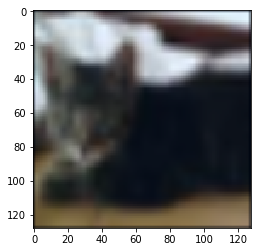

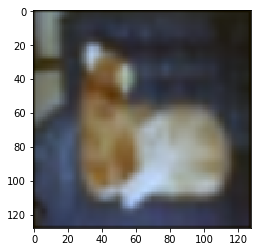

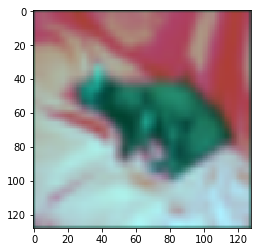

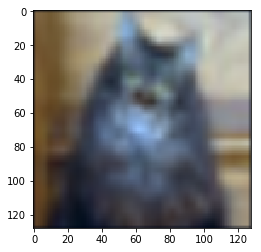

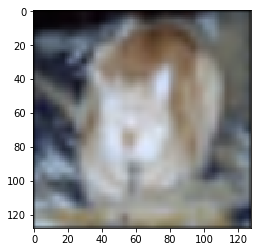

In [6]:
%aimport student

N = 5
L = 3
class_string, query_images = student.get_N_cifar_images(N, L, x_train, y_train)
print ("Visualizing class: " + class_string)
for i in range(N):
    show_image(query_images[i])

## Part 1: Questions
1. Why is it important to have train, validation, and test splits?
2. What was the original size of the CIFAR-10 images before we resized them?

## Enter your answers in `student.py`!
You should see space below TODO 3 where you can enter your answers.

# Part 2: Fitting the data

### High-Level Overview
Now that our data is preprocessed and ready, we can attempt to fit it using a convolutional neural network. This network will learn to classify input images into one of the ten CIFAR-10 categories, based on the training data that we provide to it. We will use our validation and test datasets to get a sense of how the network performs on unseen data.

### Transfer Learning
Training a network from scratch on a large dataset can take a _lot_ of time and computational resources. Nowadays, it is extremely common to use the concept of transfer learning to help quicken the training process. In transfer learning, we start with a network obtained by _others_ while training for a similar task, and then we manipulate the network slightly to fit our own task.

In this assignment, we will build upon the MobileNet network architecture published by Google in 2017. Google spent a lot of time and resources (which they have a lot of!) to train MobileNet on the ImageNet database. ImageNet is a database of 1,000 image classes, and is often used as a benchmark for image classification tasks. Thankfully for us, Google published the network weights that they obtained after training MobileNet on ImageNet, and we will now reuse those weights to build a CIFAR-10 classifier relatively quickly!

_Optional: if you're interested in learning more about MobileNet, check out the original paper [here](https://arxiv.org/pdf/1704.04861.pdf)! The main objective of this architecture, as the name suggests, is to perform well in resource-constrained embedded devices, such as our mobiles._

#### Step 1: Load in the base MobileNet model with the pre-trained weights
We're using the Keras library for this assignment, and it has an in-built function that lets us ask for a copy of the MobileNet network. We provide our image shape, and ask Keras to incorporate pre-trained weights from the time MobileNet was trained on ImageNet. ImageNet, however, has 1,000 classes, which means that the final layers of this network are constructed to have 1,000 outputs. We will replace these final layers with our own layers that will instead produce 10 outputs. The `include_top=False` argument tells Keras to get rid of those final layers for us.

In [7]:
base_model = keras.applications.mobilenet.MobileNet(input_shape=(image_size, image_size, 3), 
                                                      include_top=False, weights='imagenet')

#### Step 2: Add our own layers to the top of the base model
Keras provides us with high-level functions to add our own layers to the convolutional network. We will add a Global Average Pooling layer, followed by a fully-connected layer with 256 units (ReLU activation) and a softmax layer with 10 outputs. Between the fully-connected layer and the softmax layer, we will add a Dropout layer which should randomly drop its inputs at a rate of 50%.

**TODO 4:** In `student.py`, complete the function `build_cifar_top` that adds layers to the top of the network according to the above specification. To get you started, we have included the code that adds the Global Average Pooling layer. You might find the [Keras documentation for common layers](https://keras.io/layers/core/) helpful! Feel free to add any necessary layer imports to the top of the `student.py` file.

After completing TODO 4, run the cell below to stitch the new layers together on top of the base MobileNet model.

In [8]:
%aimport student

cifar_output = student.build_cifar_top(base_model.output)
cifar_model = Model(inputs = base_model.input, outputs=cifar_output)

#### Step 3: Inspect the network's architecture
To verify that we added the correct layers above, we can inspect the model's architecture using the following cell. You should see the four layers that we added above sitting at the end of the network. You should see 100 layers (0 through 99) listed!

In [9]:
for i, layer in enumerate(cifar_model.layers):
   print(i, layer.name)

(0, 'input_1')
(1, 'conv1_pad')
(2, 'conv1')
(3, 'conv1_bn')
(4, 'conv1_relu')
(5, 'conv_pad_1')
(6, 'conv_dw_1')
(7, 'conv_dw_1_bn')
(8, 'conv_dw_1_relu')
(9, 'conv_pw_1')
(10, 'conv_pw_1_bn')
(11, 'conv_pw_1_relu')
(12, 'conv_pad_2')
(13, 'conv_dw_2')
(14, 'conv_dw_2_bn')
(15, 'conv_dw_2_relu')
(16, 'conv_pw_2')
(17, 'conv_pw_2_bn')
(18, 'conv_pw_2_relu')
(19, 'conv_pad_3')
(20, 'conv_dw_3')
(21, 'conv_dw_3_bn')
(22, 'conv_dw_3_relu')
(23, 'conv_pw_3')
(24, 'conv_pw_3_bn')
(25, 'conv_pw_3_relu')
(26, 'conv_pad_4')
(27, 'conv_dw_4')
(28, 'conv_dw_4_bn')
(29, 'conv_dw_4_relu')
(30, 'conv_pw_4')
(31, 'conv_pw_4_bn')
(32, 'conv_pw_4_relu')
(33, 'conv_pad_5')
(34, 'conv_dw_5')
(35, 'conv_dw_5_bn')
(36, 'conv_dw_5_relu')
(37, 'conv_pw_5')
(38, 'conv_pw_5_bn')
(39, 'conv_pw_5_relu')
(40, 'conv_pad_6')
(41, 'conv_dw_6')
(42, 'conv_dw_6_bn')
(43, 'conv_dw_6_relu')
(44, 'conv_pw_6')
(45, 'conv_pw_6_bn')
(46, 'conv_pw_6_relu')
(47, 'conv_pad_7')
(48, 'conv_dw_7')
(49, 'conv_dw_7_bn')
(50, 'conv

#### Step 4: Freezing Weights
The advantage of transfer learning is that we can reuse the weights that have been obtained by someone else for a similar dataset. ImageNet and CIFAR-10 both deal with natural images and are reasonably similar to each other (though ImageNet is far more extensive). This means that we can reuse most of the weights from the base model, and we don't need to re-train the _whole_ network from scratch. We can just focus on training the last few layers that we added, and trust the base model's weights with the rest. This practice is called 'freezing' weights -- i.e., we disallow certain weights in the network from being trained, and instead let them remain constant.

**TODO 5**: In `student.py`, complete the function `freeze_model_weights` which freezes the weights of the first `to_freeze` layers of a given network, `model`. The docstring has hints on how you can go about doing this.

The cell below uses the function you wrote in TODO 5 to freeze all the original ImageNet weights (up to layer 96) that came from the base model. We will proceed to train just the final few added layers!

In [10]:
student.freeze_model_weights(cifar_model, 96)

#### Step 5: Compiling the model
In the following cell, we tell Keras what optimizer we would like to use, what type of loss function we are looking to minimize, and what metrics we would like to track during the training process.

In [11]:
cifar_model.compile(Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

#### Step 6: Fit the model to the data
Finally, we provide our training data to the model along with some training parameters like the number of epochs and the batch size. We also give Keras our validation data, and it will evaluate the validation loss and accuracy at the end of each epoch.

**Note: this step will take a few minutes to complete. Keras will show you a progress bar with the estimated time left per epoch. It varies from computer to computer, but you can expect it to take somewhere around 8 minutes per epoch on a standard computer.**

In [12]:
cifar_model.fit(x_train, y_train, epochs=2, batch_size=16, validation_data=(x_val, y_val))

Train on 4500 samples, validate on 500 samples
Epoch 1/2
4500/4500 [==============================] - 441s 98ms/step - loss: 1.6216 - categorical_accuracy: 0.4507 - val_loss: 1.5053 - val_categorical_accuracy: 0.4860
Epoch 2/2
4500/4500 [==============================] - 424s 94ms/step - loss: 1.1253 - categorical_accuracy: 0.6167 - val_loss: 1.1694 - val_categorical_accuracy: 0.6400


#### Step 7: Evaluate the model
Lastly, we use the unseen test data to get a true evaluation of how good (or bad) our trained model is.

In [13]:
cifar_score = cifar_model.evaluate(x_test, y_test, batch_size=16)
print("test loss: " + str(cifar_score[0]) + ", test acc: " + str(cifar_score[1]))

500/500 [==============================] - 47s 95ms/step
test loss: 1.2082937526702882, test acc: 0.62


#### Step 8: Observe predictions
Now, let's take a look at the predictions that our network makes on some example images from the test set.

**TODO 6:** In `student.py`, complete the `generate_predictions` function. This takes a batch of test images as input, and runs them through the given model to generate predictions. For each image in the batch, the class label and score of the predicted class is returned.

('Prediction: cat', '0.32630512')
True label: cat


/home/ubuntu/anaconda2/envs/pa5/lib/python2.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
  


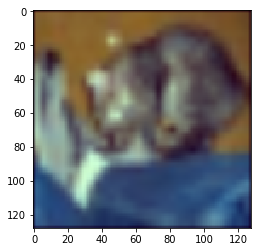

('Prediction: airplane', '0.34845528')
True label: ship


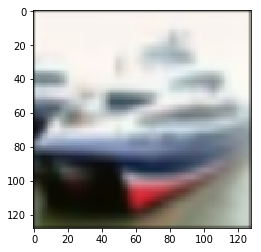

('Prediction: bird', '0.22674787')
True label: ship


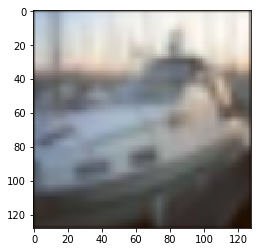

('Prediction: airplane', '0.46080264')
True label: airplane


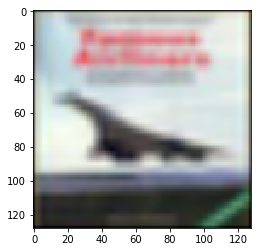

('Prediction: cat', '0.27544335')
True label: frog


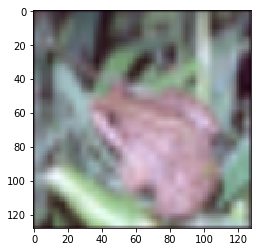

In [28]:
%aimport student

test_batch_size = 20
x_batch = x_test[:test_batch_size]
y_batch = y_test[:test_batch_size]
labels_batch, scores_batch = student.generate_predictions(cifar_model, x_batch)
for i in range(test_batch_size):
    print("Prediction: " + str(cifar_classes[labels_batch[i]]), str(scores_batch[i]))
    print("True label: " + str(cifar_classes[np.argmax(y_batch[i])]))
    show_image(x_batch[i])

## Part 2: Questions
1. What is an 'epoch'?
2. What is meant by 'batch size'?
3. How does the loss function being used relate to negative log likelihood discussed in class?
4. List the final training, validation, and test accuracies of your model.
5. Suggest one change to the layers that we added that could result in a higher accuracy.

## Enter your answers in `student.py`!
You should see space below TODO 6 where you can enter your answers.

# Part 3: Animals vs Vehicles

At this stage, our neural network has obtained a reasonable amount of knowledge about the CIFAR-10 classes. You might have noticed that the CIFAR-10 classes consist of two broad categories -- animals and vehicles. Can we now reuse the network's learned knowledge to create a network that distinguishes between animals and vehicles?

_**Animals:** bird, cat, deer, dog, frog, horse_;
_**vehicles:** airplane, automobile, ship, truck_

We can once again use transfer learning, and this time we can re-use the weights that the CIFAR-10 model learned rather than go back to the base model. More details on that later, but to begin with, we need to change our training data.

#### Step 1: Change the labels
We can think of this problem as a 2-class classification problem, with animals and vehicles as two classes. Our original labels, however, came from CIFAR-10 which has 10 classes. We will need to adjust these original target labels in order to train a network that distinguishes between animals and vehicles.

**TODO 7:** In `student.py`, complete the `change_labels_av` function which uses `y_train`, `y_val` and `y_test` to create adjusted labels for the 2-class animals vs vehicles problem.

In [40]:
%aimport student

y_train_av, y_val_av, y_test_av = student.change_labels_av(y_train, y_val, y_test)

(2735.0, 1765.0)


#### Step 2: Change the output layer
The CIFAR-10 model outputs 10 probabilities, but this problem requires us to output 2 probabilities. We will keep all the layers of `cifar_model`, except the very last (softmax) layer. Instead of it, we will add a softmax layer with 2 outputs.

**TODO 8:** In `student.py`, implement `build_av_top` which adds a 2-unit softmax layer to the top of the existing CIFAR model.

In [31]:
%aimport student

av_output = student.build_av_top(cifar_model.layers[98].output) # bypass the last layer (softmax, layer 99) of cifar_model
av_model = Model(inputs = cifar_model.input, outputs=av_output)

#### Step 3: Inspect the model's architecture
Once again, let's take a look at the layers in the model to make sure it matches our expectations. There should again be 100 layers listed (0-99), and you should see your newly added layer at the very bottom.

In [32]:
for i, layer in enumerate(av_model.layers):
   print(i, layer.name)

(0, 'input_1')
(1, 'conv1_pad')
(2, 'conv1')
(3, 'conv1_bn')
(4, 'conv1_relu')
(5, 'conv_pad_1')
(6, 'conv_dw_1')
(7, 'conv_dw_1_bn')
(8, 'conv_dw_1_relu')
(9, 'conv_pw_1')
(10, 'conv_pw_1_bn')
(11, 'conv_pw_1_relu')
(12, 'conv_pad_2')
(13, 'conv_dw_2')
(14, 'conv_dw_2_bn')
(15, 'conv_dw_2_relu')
(16, 'conv_pw_2')
(17, 'conv_pw_2_bn')
(18, 'conv_pw_2_relu')
(19, 'conv_pad_3')
(20, 'conv_dw_3')
(21, 'conv_dw_3_bn')
(22, 'conv_dw_3_relu')
(23, 'conv_pw_3')
(24, 'conv_pw_3_bn')
(25, 'conv_pw_3_relu')
(26, 'conv_pad_4')
(27, 'conv_dw_4')
(28, 'conv_dw_4_bn')
(29, 'conv_dw_4_relu')
(30, 'conv_pw_4')
(31, 'conv_pw_4_bn')
(32, 'conv_pw_4_relu')
(33, 'conv_pad_5')
(34, 'conv_dw_5')
(35, 'conv_dw_5_bn')
(36, 'conv_dw_5_relu')
(37, 'conv_pw_5')
(38, 'conv_pw_5_bn')
(39, 'conv_pw_5_relu')
(40, 'conv_pad_6')
(41, 'conv_dw_6')
(42, 'conv_dw_6_bn')
(43, 'conv_dw_6_relu')
(44, 'conv_pw_6')
(45, 'conv_pw_6_bn')
(46, 'conv_pw_6_relu')
(47, 'conv_pad_7')
(48, 'conv_dw_7')
(49, 'conv_dw_7_bn')
(50, 'conv

#### Step 4: Freezing Weights
This time, we will reuse our learned weights from the CIFAR-10 model in addition to the original ImageNet weights that MobileNet came packaged with. This means that the only layer we need to keep unfrozen is the last layer which we just added (layer 99). We can reuse the `freeze_model_weights` function to do this.

In [33]:
student.freeze_model_weights(av_model, 99)

#### Step 5: Compiling the model
Just as before, we specify the optimizer to use, the loss function to optimize, and the metrics to track during training.

In [34]:
av_model.compile(Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

#### Step 6: Fit the model to the data
We pass in our adjusted labels, `y_train_av` and `y_val_av`, as the training and validation target labels.

**Note: Just like Step 6 of Part 2, this step will take a few minutes to complete. Keras will show you a progress bar with the estimated time left per epoch. It varies from computer to computer, but you can expect it to take somewhere around 8 minutes per epoch on a standard computer.**

In [35]:
av_model.fit(x_train, y_train_av, epochs=2, batch_size=16, validation_data=(x_val, y_val_av))

Train on 4500 samples, validate on 500 samples
Epoch 1/2
4500/4500 [==============================] - 430s 96ms/step - loss: 0.4267 - categorical_accuracy: 0.8096 - val_loss: 0.2840 - val_categorical_accuracy: 0.9020
Epoch 2/2
4500/4500 [==============================] - 424s 94ms/step - loss: 0.2407 - categorical_accuracy: 0.9013 - val_loss: 0.2665 - val_categorical_accuracy: 0.9040


#### Step 7: Evaluate the model
We use our updated test labels, `y_test_av`, as the ground truth labels.

In [36]:
av_score = av_model.evaluate(x_test, y_test_av, batch_size=16)
print("test loss: " + str(av_score[0]) + ", test acc: " + str(av_score[1]))

500/500 [==============================] - 47s 94ms/step
test loss: 0.25792137110233304, test acc: 0.932


#### Step 8: Observing predictions
We can reuse the `generate_predictions` function to observe the predictions made by `av_model`.

In [39]:
%aimport student

test_batch_size = 40
x_batch = x_test[:test_batch_size]
y_batch = y_test_av[:test_batch_size]
labels_batch, scores_batch = student.generate_predictions(av_model, x_batch)
for i in range(test_batch_size):
    print("Prediction: " + str(av_classes[labels_batch[i]]), str(scores_batch[i]))
    print("True label: " + str(av_classes[np.argmax(y_batch[i])]))
    #show_image(x_batch[i])

('Prediction: animal', '0.89122576')
True label: animal
('Prediction: vehicle', '0.83607733')
True label: vehicle
('Prediction: vehicle', '0.6786055')
True label: vehicle
('Prediction: vehicle', '0.8298597')
True label: vehicle
('Prediction: animal', '0.8722189')
True label: animal
('Prediction: vehicle', '0.5060066')
True label: animal
('Prediction: vehicle', '0.9287918')
True label: vehicle
('Prediction: animal', '0.9788417')
True label: animal
('Prediction: animal', '0.98136693')
True label: animal
('Prediction: vehicle', '0.6627152')
True label: vehicle
('Prediction: vehicle', '0.722215')
True label: vehicle
('Prediction: vehicle', '0.86914474')
True label: vehicle
('Prediction: animal', '0.99646384')
True label: animal
('Prediction: animal', '0.9535831')
True label: animal
('Prediction: vehicle', '0.7081371')
True label: vehicle
('Prediction: vehicle', '0.54168636')
True label: vehicle
('Prediction: animal', '0.9850369')
True label: animal
('Prediction: animal', '0.95196056')
True

## Part 3: Questions
1. Approximately what percentage of our training examples belong to the animal class?
2. What would happen if less than 10% of our training examples belonged to the animal class?
3. How many trainable parameters does `av_model` contain? Briefly explain how you arrived at this number.

## Enter your answers in `student.py`!
You should see space below TODO 8 where you can enter your answers.

# Part 4: Occlusion Sensitivity

While the inner workings of convolutional neural networks may not be immediately obvious, we can use certain methods to understand the knowledge that they have learned. Researchers have come up with several ways to help us visualize the internal knowledge of networks; in this part, we will be implementing one such method called occlusion sensitivity.

#### Occlusion Sensitivity
To understand how a neural network is making predictions, one question we might want to ask is, "What part of the image is the network looking at while making its prediction?" One way of answering this is using the concept of occlusion sensitivity: we slide an occlusion window over different parts of the image, and we see which of the occlusions causes the network to be least confident about the correct answer. The occlusion which produces the prediction with least confidence is likely to have covered a part of the image that was very important for the network. We will implement a simple version of occlusion sensitivity to get a sense of what parts of the images our trained network is looking at.

_If you're interested in learning more about occlusion sensitivity, check out the [original paper](https://arxiv.org/pdf/1311.2901.pdf) that was published by researchers at NYU._

#### Step 1: Generate occluded images
As the first step, we will slide a black window over a given image to produce a batch of occluded images.

**TODO 9:** In `student.py`, implement the function `generate_occlusions`. This function will slide an occlusion window of size `occlusion_size` in a non-overlapping way over the given example image. It returns a batch of images, each of which is an occlusion of the original image.

Run the cell below to generate the occluded images. Make sure they're in the right order as specified in the docstring for `generate_occlusions`! Also note that you should expect the occluded regions to appear grey and not black, even though we set the pixels to 0. This is because of our dataset preprocessing; 0 is made to correspond to the channel-wise mean of the dataset, which should be a shade of grey.

/home/ubuntu/anaconda2/envs/pa5/lib/python2.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
  


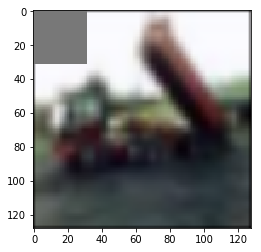

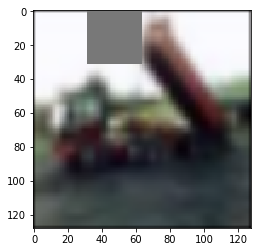

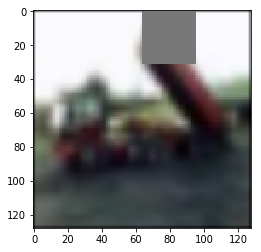

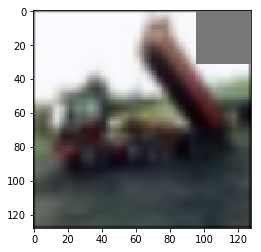

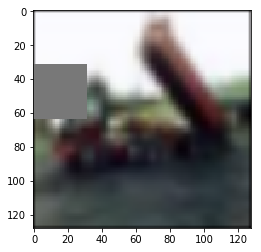

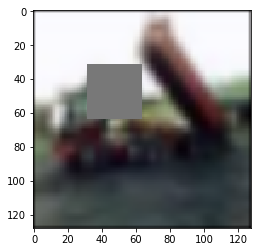

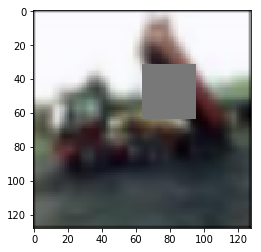

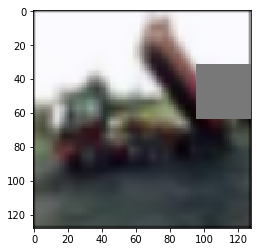

In [63]:
%aimport student

occlusion_size = 32
example_index = 2              # feel free to play around with example_index to see more examples!
original_image = x_train[example_index]
occ_images = student.generate_occlusions(original_image, occlusion_size)
for occ_image in occ_images:
    show_image(occ_image)

#### Step 2: Find the most sensitive occlusion region
We will now use our CIFAR-10 classifier, `cifar_model`, to predict the class scores for each of the occluded images. Then, we can use these predictions to find the occlusion that most negatively impacts the score of the correct image class.

**TODO 10:** In `student.py`, implement the function `find_worst_occlusion`. This function generates predictions for each image in the given batch of occluded images, using the model that is passed into it. Then, it finds the occluded image that attributed the lowest score to the correct image class.

After completing TODO 10, run the cell below to find the occluded image with the worst score. The hidden region in this image is the occlusion that the network thinks is _most_ important for correct classification. One way to interpret this is as follows: if you're looking at an example with a horse, and the horse's mane is hidden by the occlusion, then the network is likely using the mane to distinguish it from the other CIFAR-10 classes.

Note that the results here will not be perfect: our model has been trained very lightly, and only on a small subset of the CIFAR-10 dataset. However, this exercise hopefully gives you insight into how we might understand what a neural network has learned from the training data!

Original image


/home/ubuntu/anaconda2/envs/pa5/lib/python2.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
  


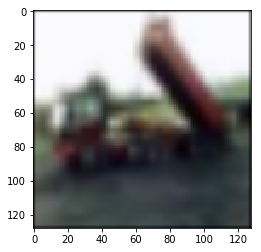

Worst occlusion (score = 0.027757818)


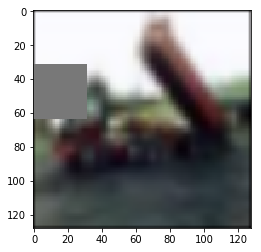

In [66]:
%aimport student

worst_occ_im, worst_occ_score = student.find_worst_occlusion(occ_images, cifar_model, y_train[example_index])
print("Original image")
show_image(original_image)
print("Worst occlusion (score = " + str(worst_occ_score) + ")")
show_image(worst_occ_im)

# Part 5: Adversarial Examples

Convolutional neural networks are extremely powerful models when it comes to images; today, they are used extensively in drug discovery, disease detection, self-driving cars, and more. However, they are far from perfect. Turns out, these networks can be tricked very easily, using the concept of _adversarial examples_. In this part, we will generate adversarial examples to trick our own CIFAR-10 model.

#### High-Level Overview
We start with an image, $I$, that is classified correctly as class $C$. Our objective is to manipulate the image $I$ by adding small changes to it which would make the network predict it as a target class, $C_{target}$. We can do so by observing the gradients produced within the model. Essentially, we find the direction in which we must change each input image pixel to increase the score of the target class, and we give the image's pixels a slight nudge in that direction. We do this repeatedly a few times, and very soon we have a new image, $I_{target}$, that the network is confident belongs to the target class $C_{target}$.

The scary part is that $I_{target}$ contains tiny, imperceptible changes relative to $I$; to the human eye, $I$ and $I_{target}$ visually look like the same image. Yet, the model perceives these two images completely differently.

#### Step 1: Compute the required gradients
To find adversarial examples, we need to find the gradient of the score of the target class (in the softmax layer) relative to the model's input. The following cell defines a function, `get_gradients`, which takes an image as input and returns the normalized gradient of the score of the target class with respect to the input image.

In [72]:
c_target = 0 # airplane, feel free to change this!
target_score = K.mean(cifar_model.output[:, c_target])
grads = K.gradients(target_score, cifar_model.input)[0]
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
get_gradients = K.function([cifar_model.input], [target_score, grads])

#### Step 2: Perform gradient ascent on the image
Now, we can start with some original image and move it towards the target class by performing gradient ascent on it for some number of steps. At each step, we retrieve $G = \frac{\partial s_{target}}{\partial I}$, where $s_{target}$ represents the score of the target class. We can perform gradient ascent to move I in the direction that maximizes $s_{target}$:

$$I_{t+1} = I_t + \alpha G$$

where $\alpha$ is the step size.

**TODO 11:** In `student.py`, implement the function `generate_adversarial` which performs gradient ascent on an image using the given `get_gradients` function. This should result in a final image that looks similar to the original image, but is classified as belonging to the `c_target` class declared above. The function should return the final image, and also the difference between the final and the original image, normalized along the axis containing the channels.

Original image


/home/ubuntu/anaconda2/envs/pa5/lib/python2.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
  


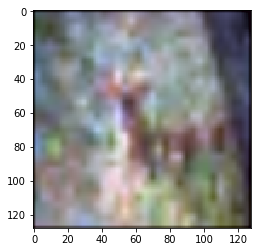

Tricking the network into thinking that this is a(n) airplane...
Changed image (target score = 0.7485124)


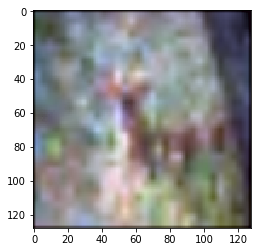

Normalized difference between images


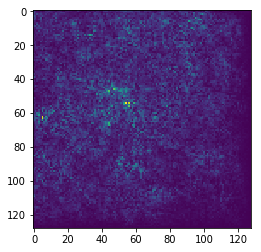

In [80]:
%aimport student

example_index = 10 # feel free to play around with the example image index!
original_image = x_train[example_index]
alpha = 0.001
num_steps = 20

changed_image, diff_image = student.generate_adversarial(np.copy(original_image), get_gradients, alpha, num_steps)
student.generate_adversarial(np.copy(original_image), get_gradients, alpha, num_steps)
new_prediction = cifar_model.predict(changed_image[np.newaxis,:,:,:])[0, c_target]
print("Original image")
show_image(original_image)
print("Tricking the network into thinking that this is a(n) " + cifar_classes[c_target] + "...")
print("Changed image (target score = " + str(new_prediction) + ")")
show_image(changed_image)
print("Normalized difference between images")
show_image(diff_image)

#### On a positive note...
While this may seem like a dealbreaker for convolutional neural networks, a lot of research is being done on the topic of adversarial examples. People have been finding ways to make our networks more robust to adversarial attacks, and there's also a whole class of networks called Generative Adversarial Networks (GANs) that rely on the concept of adversarial actors to generate new, synthetic data for a given dataset.

If you're interested in learning more about any of these topics, please post on Piazza and we'd be happy to share more resources :)